# Dataset prepareation
First the dataset needs to be loaded and modified to only include the labels we want. This is done by merging unchosen labels to their closest related label. Cases where text has multiple labels for one entry are handled by choosing the label which has the lowest representation in the dataset so far.

In [1]:
from data.dataset import EmotionsDataset

train_dataset = EmotionsDataset(split="train")
valid_dataset = EmotionsDataset(split="valid")
test_dataset = EmotionsDataset(split="test")


No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


In [2]:
print(train_dataset[0])
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

("My favourite food is anything I didn't have to cook myself.", 13)
43410
5426
5427


# Evalutation Methods
## Confusion Matrix
A confusion matrix is used to visualise the performance of the classifier, this helps us see which labels the classifiers are making the most mistakes on.
The dataset is largely saturated by neutral tags, this means a raw confusion matrix turns out dark for all values apart from neural-neutral, to solve this my confusion matrix displays the log values.

In [3]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from data.dataset import label_names, chosen_labels

from typing import Tuple, Optional

def get_label_names():
    names = []

    for label in chosen_labels:
        names.append(label_names[label])
    names.append(label_names[27])

    return names

def display_confusion_matrix(preds, y, scale="linear", save_name: Optional[Tuple[str, str]] = None):
    confusion_matrix = np.zeros((14,14)).astype(np.int32)

    for pred, label in zip(preds, y):
        confusion_matrix[pred, label] += 1

    if scale == "log":
        confusion_matrix = np.log2(confusion_matrix+1)
    
    chosen_label_names = get_label_names()
    heatmap_confusion_matrix = pd.DataFrame(confusion_matrix, index=chosen_label_names, columns=chosen_label_names)

    ax = plt.axes()
    sb.heatmap(heatmap_confusion_matrix, annot=True, ax=ax)
    scale_title = scale[0].upper() + scale[1:]
    ax.set_title(f"{scale_title} Confusion Matrix")

    if save_name != None:
        plt.savefig(f"./figures/{save_name[0]}/{save_name[1]}.png")

    plt.show()


## Precision, Recall, F1 Score
To keep track of the performance of each experiment on an induvidual label, by tracking how often a label is corrcetly guessed out of the the instances of that label and how ofter a guess of a label is correct out of all the guesses of that label.

In [4]:
from sklearn.metrics import precision_recall_fscore_support

def get_scores(labels, predictions, kernel_type = "linear", save_dir = "general"):
    prec, recall, f1, support = precision_recall_fscore_support(labels, predictions)

    results_dictionary = {"label":list(range(14)), "precision":prec, "recall":recall, "f1":f1}
    results = pd.DataFrame(results_dictionary)
    results.to_csv(f"figures/{save_dir}/{kernel_type}_kernel_metrics.csv", index=False)

    return results

# Experiment 1: Different SVM kernel types
This experiment looks at the different kernel options used to build a support vector, the kernels covered are: linear, polynomial, radial basis function and sigmoid.
## Vectorisation using TFIDF 
The input text needs to be vectorised before it can be used for training a support vector machine. First stop words and non-alphabetic words are removed before being lemmatised. 

In [5]:
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download, pos_tag
download('punkt')
download('wordnet')
download('omw-1.4')
download('averaged_perceptron_tagger')
download('stopwords')

from collections import defaultdict

def lem_text(text):
    text = [word.lower() for word in text]
    text = [word_tokenize(word) for word in text]

    word_tags = defaultdict(lambda: wordnet.NOUN)
    word_tags['J'] = wordnet.ADJ
    word_tags['V'] = wordnet.VERB
    word_tags['R'] = wordnet.ADV

    for i, words in enumerate(text):
        lemmed_text = []
        lemmer = WordNetLemmatizer()

        for word, tag in pos_tag(words):
            if word not in stopwords.words('english') and word.isalpha():
                lem_word = lemmer.lemmatize(word, word_tags[tag[0]])
                lemmed_text.append(lem_word)

        text[i] = str(lemmed_text)

    return text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Once the text of all datasets has been lemmatised, the training data is used to extract the most important word tfidf features. These features are used to convert all dataset text entries into vectors.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_dataset_tfidf = EmotionsDataset(split="train")
test_dataset_tfidf = EmotionsDataset(split="test")

train_dataset_tfidf.x = lem_text(train_dataset_tfidf.x)
test_dataset_tfidf.x = lem_text(test_dataset_tfidf.x)

tfidf_vectoriser = TfidfVectorizer(max_features=1000)
tfidf_vectoriser.fit(train_dataset_tfidf.x)

train_dataset_tfidf.x = tfidf_vectoriser.transform(train_dataset_tfidf.x)
test_dataset_tfidf.x = tfidf_vectoriser.transform(test_dataset_tfidf.x)

No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


## SVM kernel results
The performance of the SVM is evaluated with accuracy, recall, precision and f1 score

### Linear Kernel

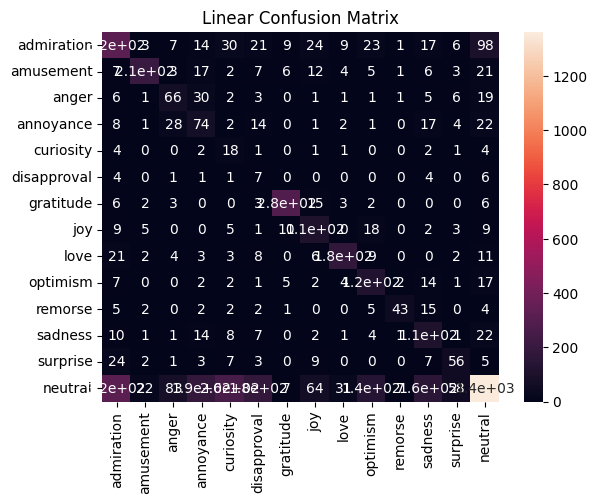

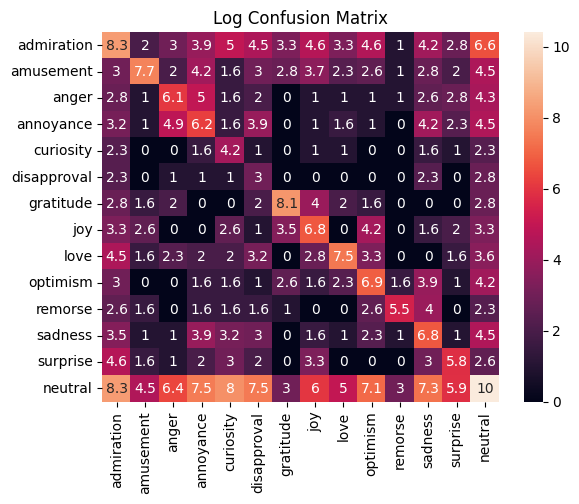

    label  precision    recall        f1
0       0   0.551370  0.426490  0.480956
1       1   0.686667  0.834008  0.753199
2       2   0.464789  0.335025  0.389381
3       3   0.425287  0.212644  0.283525
4       4   0.529412  0.052941  0.096257
5       5   0.291667  0.027027  0.049470
6       6   0.875776  0.881250  0.878505
7       7   0.637427  0.443089  0.522782
8       8   0.718367  0.758621  0.737945
9       9   0.674286  0.364198  0.472946
10     10   0.530864  0.767857  0.627737
11     11   0.600000  0.303371  0.402985
12     12   0.478632  0.397163  0.434109
13     13   0.473245  0.848070  0.607493
Testing Accuracy:  54.30256126773539


In [7]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import os

kernel_dir = "kernel_experiement"
if not os.path.exists(f"./figures/{kernel_dir}"):
    os.mkdir(f"./figures/{kernel_dir}")

svm_linear = svm.SVC(kernel='linear')
svm_linear.fit(train_dataset_tfidf.x, train_dataset_tfidf.y)
preds = svm_linear.predict(test_dataset_tfidf.x)

display_confusion_matrix(preds, test_dataset_tfidf.y, save_name=(kernel_dir, "confusion_matrix_no_scaling"))
display_confusion_matrix(preds, test_dataset_tfidf.y, scale="log", save_name=(kernel_dir, 'linear_matrix'))

acc = accuracy_score(test_dataset_tfidf.y, preds)*100

results = get_scores(test_dataset_tfidf.y, preds, kernel_type="linear", save_dir=kernel_dir)
print(results)
print("Testing Accuracy: ", acc)

### Polynomial Kernel

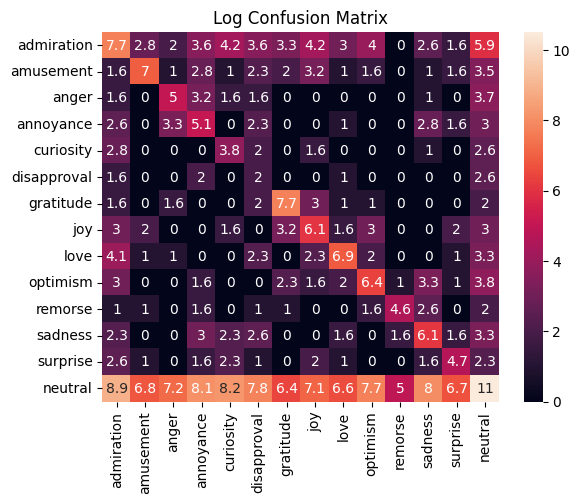

    label  precision    recall        f1
0       0   0.563830  0.280795  0.374889
1       1   0.751515  0.502024  0.601942
2       2   0.542373  0.162437  0.250000
3       3   0.500000  0.097701  0.163462
4       4   0.433333  0.038235  0.070270
5       5   0.214286  0.011583  0.021978
6       6   0.917391  0.659375  0.767273
7       7   0.628571  0.268293  0.376068
8       8   0.750000  0.504310  0.603093
9       9   0.664000  0.256173  0.369710
10     10   0.589744  0.410714  0.484211
11     11   0.656863  0.188202  0.292576
12     12   0.520833  0.177305  0.264550
13     13   0.373402  0.909091  0.529369
Testing Accuracy:  45.5131748664087


In [8]:
svm_poly = svm.SVC(kernel='poly')
svm_poly.fit(train_dataset_tfidf.x, train_dataset_tfidf.y)
preds = svm_poly.predict(test_dataset_tfidf.x)

display_confusion_matrix(preds, test_dataset_tfidf.y, scale="log", save_name=(kernel_dir, 'poly_matrix'))

acc = accuracy_score(test_dataset_tfidf.y, preds)*100
prec, recall, f1, support = precision_recall_fscore_support(test_dataset_tfidf.y, preds)

results = get_scores(test_dataset_tfidf.y, preds, kernel_type="poly", save_dir=kernel_dir)

print(results)
print("Testing Accuracy: ", acc)

### Sigmoid Kernel

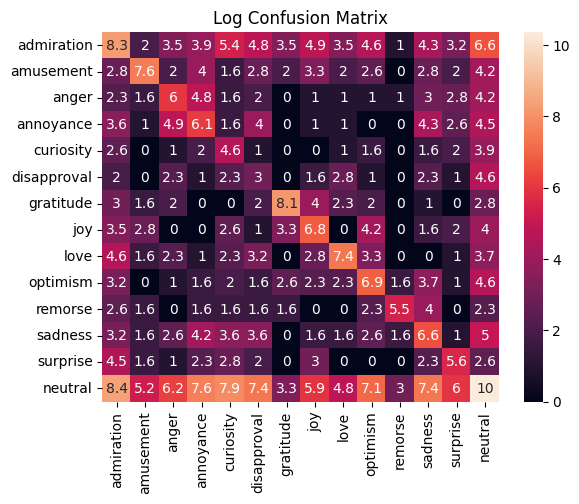

    label  precision    recall        f1
0       0   0.511706  0.405298  0.452328
1       1   0.704120  0.761134  0.731518
2       2   0.466667  0.319797  0.379518
3       3   0.402299  0.201149  0.268199
4       4   0.428571  0.070588  0.121212
5       5   0.122807  0.027027  0.044304
6       6   0.865031  0.881250  0.873065
7       7   0.616667  0.451220  0.521127
8       8   0.711934  0.745690  0.728421
9       9   0.636364  0.367284  0.465753
10     10   0.530864  0.767857  0.627737
11     11   0.489583  0.264045  0.343066
12     12   0.470588  0.340426  0.395062
13     13   0.465536  0.820050  0.593912
Testing Accuracy:  52.423069836005155


In [9]:
svm_sig = svm.SVC(kernel='sigmoid')
svm_sig.fit(train_dataset_tfidf.x, train_dataset_tfidf.y)
preds = svm_sig.predict(test_dataset_tfidf.x)

display_confusion_matrix(preds, test_dataset_tfidf.y, scale="log", save_name=(kernel_dir, 'sigmoid_matrix'))

acc = accuracy_score(test_dataset_tfidf.y, preds)*100

results = get_scores(test_dataset_tfidf.y, preds, kernel_type="sigmoid", save_dir=kernel_dir)

print(results)
print("Testing Accuracy: ", acc)

### Radial Basis Function Kernel

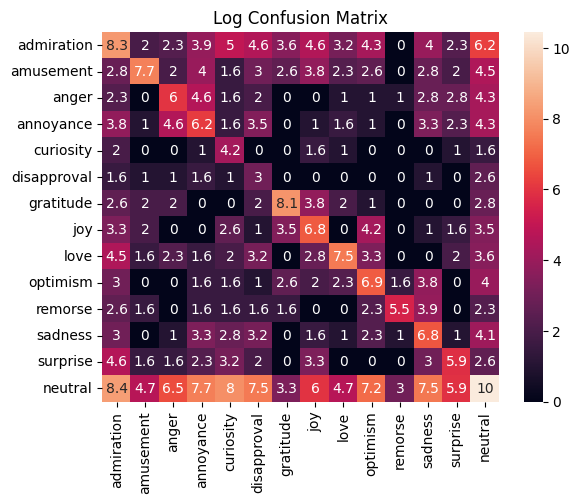

    label  precision    recall        f1
0       0   0.575139  0.410596  0.479134
1       1   0.692568  0.829960  0.755064
2       2   0.488550  0.324873  0.390244
3       3   0.458599  0.206897  0.285149
4       4   0.642857  0.052941  0.097826
5       5   0.350000  0.027027  0.050179
6       6   0.882540  0.868750  0.875591
7       7   0.654971  0.455285  0.537170
8       8   0.723320  0.788793  0.754639
9       9   0.684211  0.361111  0.472727
10     10   0.548780  0.803571  0.652174
11     11   0.656442  0.300562  0.412331
12     12   0.471074  0.404255  0.435115
13     13   0.468792  0.869863  0.609246
Testing Accuracy:  54.763220932375155


In [10]:
svm_rbf = svm.SVC(kernel='rbf')
svm_rbf.fit(train_dataset_tfidf.x, train_dataset_tfidf.y)
preds = svm_rbf.predict(test_dataset_tfidf.x)

display_confusion_matrix(preds, test_dataset_tfidf.y, scale="log", save_name=(kernel_dir, 'rbf_matrix'))

acc = accuracy_score(test_dataset_tfidf.y, preds)*100

results = get_scores(test_dataset_tfidf.y, preds, kernel_type="rbf", save_dir=kernel_dir)

print(results)
print("Testing Accuracy: ", acc)

# Experiment 2: SVM Hyper-parameter tuning
I will tune the hyper-parameters of SVM while keeping the kernel the same. I will use the radial basis function kernel as it has provided the best results in experiment 1.
## Grid Search
The hyper-parameters will be searched using a grid search technique. I will select a set of discrete values for each variable that I am changing. The variables I will focus on will be: the regularisation parameter, gamma value and stopping tolerance.

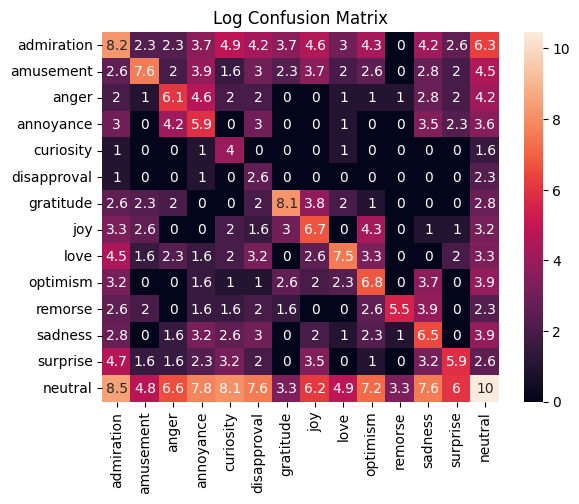

    label  precision    recall        f1
0       0   0.571429  0.397351  0.468750
1       1   0.698246  0.805668  0.748120
2       2   0.511628  0.335025  0.404908
3       3   0.508621  0.169540  0.254310
4       4   0.750000  0.044118  0.083333
5       5   0.454545  0.019305  0.037037
6       6   0.880878  0.878125  0.879499
7       7   0.658385  0.430894  0.520885
8       8   0.734940  0.788793  0.760915
9       9   0.689441  0.342593  0.457732
10     10   0.529412  0.803571  0.638298
11     11   0.638298  0.252809  0.362173
12     12   0.460317  0.411348  0.434457
13     13   0.456276  0.880448  0.601063
Testing Accuracy (0.5_0.5_0.01):  54.02616546895154
Training Time:  125.63569569587708


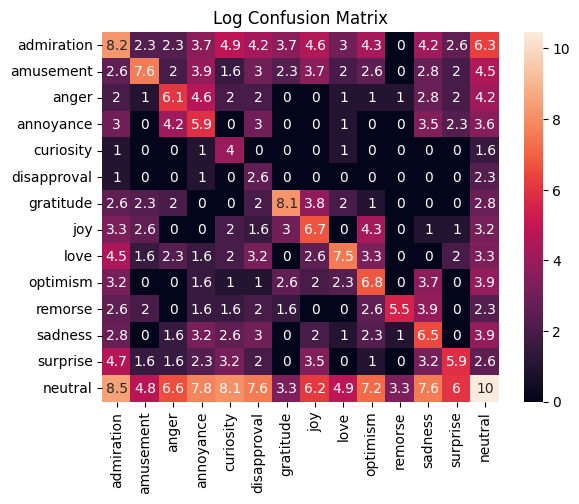

    label  precision    recall        f1
0       0   0.571429  0.397351  0.468750
1       1   0.698246  0.805668  0.748120
2       2   0.511628  0.335025  0.404908
3       3   0.508621  0.169540  0.254310
4       4   0.750000  0.044118  0.083333
5       5   0.454545  0.019305  0.037037
6       6   0.880878  0.878125  0.879499
7       7   0.658385  0.430894  0.520885
8       8   0.734940  0.788793  0.760915
9       9   0.689441  0.342593  0.457732
10     10   0.529412  0.803571  0.638298
11     11   0.638298  0.252809  0.362173
12     12   0.460317  0.411348  0.434457
13     13   0.456276  0.880448  0.601063
Testing Accuracy (0.5_0.5_0.001):  54.02616546895154
Training Time:  153.1234254837036


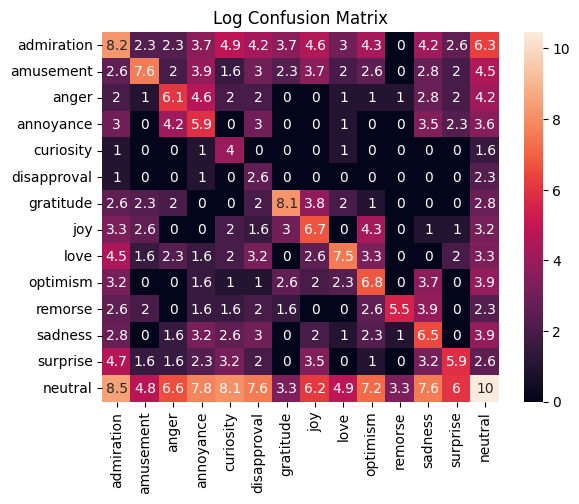

    label  precision    recall        f1
0       0   0.571429  0.397351  0.468750
1       1   0.698246  0.805668  0.748120
2       2   0.511628  0.335025  0.404908
3       3   0.508621  0.169540  0.254310
4       4   0.750000  0.044118  0.083333
5       5   0.454545  0.019305  0.037037
6       6   0.880878  0.878125  0.879499
7       7   0.658385  0.430894  0.520885
8       8   0.734940  0.788793  0.760915
9       9   0.689441  0.342593  0.457732
10     10   0.529412  0.803571  0.638298
11     11   0.638298  0.252809  0.362173
12     12   0.460317  0.411348  0.434457
13     13   0.456276  0.880448  0.601063
Testing Accuracy (0.5_0.5_0.0001):  54.02616546895154
Training Time:  167.47331190109253


In [13]:
import time

c_values = [0.5, 0.75, 1, 1.25, 1.5]
g_values = [0.5, 0.75, 1, 1.25, 1.5]
t_values = [1e-2, 1e-3, 1e-4]

grid_search_dir = 'grid_search_experiment'
if not os.path.exists(f"./figures/{grid_search_dir}"):
    os.mkdir(f"./figures/{grid_search_dir}")

c_tracking = []
g_tracking = []
t_tracking = []
accuracy_tracking = []
time_tracking = []

for c_value in c_values:
    for g_value in g_values:
        for t_value in t_values:
            test_name = f'{c_value}_{g_value}_{t_value}'

            svm_rbf = svm.SVC(kernel='rbf', C=c_value, gamma=g_value, tol=t_value)

            start = time.time()
            svm_rbf.fit(train_dataset_tfidf.x, train_dataset_tfidf.y)
            end = time.time()

            preds = svm_rbf.predict(test_dataset_tfidf.x)

            display_confusion_matrix(preds, test_dataset_tfidf.y, scale="log", save_name=(grid_search_dir, f'{test_name}_matrix'))

            acc = accuracy_score(test_dataset_tfidf.y, preds)*100

            results = get_scores(test_dataset_tfidf.y, preds, kernel_type=test_name, save_dir=grid_search_dir)

            print(results)
            print(f"Testing Accuracy ({test_name}): ", acc)
            print("Training Time: ", end-start)

            c_tracking.append(c_value)
            g_tracking.append(g_value)
            t_tracking.append(t_value)
            accuracy_tracking.append(acc)
            time_tracking.append(end-start)

grid_search_summary = pd.DataFrame({"Regularisation": c_tracking, "Gamma": g_tracking, "Tolerance": t_tracking, "Accuracy": accuracy_tracking, "Training Time": time_tracking})
grid_search_summary.to_csv(f'./figures/{grid_search_dir}/summary.csv')
            

# Experiment 3: The effect of using bag of words as data preprocessing
In the prior experiments tfidf is used to vectorise the text entries, this experiment looks at how using bags of words to vectorise data can effect the performance of SVM for classification. 
## Datset preprocessing 
First the text needs to be vectorised into a bag of words, to do this the CountVecotriser is used. I've chosen to extract the 1000 most common words to build the bags (not setting a maximum size would create a bag equal to the amount of unqiue words, which would create large vectors and greatly increase processing time)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

train_dataset_bags = EmotionsDataset(split="train")
test_dataset_bags = EmotionsDataset(split="test")

train_dataset_bags.x = lem_text(train_dataset_bags.x)
test_dataset_bags.x = lem_text(test_dataset_bags.x)

bag_vectoriser = CountVectorizer(max_features=1000)
bag_vectoriser.fit(train_dataset_bags.x)

train_dataset_bags.x = bag_vectoriser.transform(train_dataset_bags.x)
test_dataset_bags.x = bag_vectoriser.transform(test_dataset_bags.x)

## Training and evaluation


In [ ]:
bag_dir = 'bag_of_words_experiment'
if not os.path.exists(f"./figures/{bag_dir}"):
    os.mkdir(f"./figures/{bag_dir}")

svm_bag = svm.SVC(kernel='rbf')
svm_bag.fit(train_dataset_bags.x, train_dataset_bags.y)
preds = svm_bag.predict(test_dataset_bags.x)

display_confusion_matrix(preds, test_dataset_bags.y, scale="log", save_name=(bag_dir, 'bag_matrix'))

acc = accuracy_score(test_dataset_bags.y, preds)*100

results = get_scores(test_dataset_bags.y, preds, kernel_type="bag", save_dir=bag_dir)

print(results)
print("Testing Accuracy: ", acc)